In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

from sklearn.cluster import KMeans

In [4]:
plt.style.use('seaborn-darkgrid')

In [5]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [6]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [15]:
# 1 point
def scale(X):
    return (X - np.mean(X)) / np.std(X)

In [16]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [206]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, copy=True, with_mean=True, with_std=True):
        self.columns = columns
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std

    def fit(self, X, y=None):
        self.mean = np.mean(X)
        self.std = np.std(X)
        return self

    def transform(self, X, y=None, copy=None):
        return (X - self.mean) / self.std

In [207]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [18]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ 5.0717089 , -0.35633132],
       [10.61569475, -0.9745771 ],
       [-4.19759597, -0.29093355],
       ...,
       [ 0.83587743,  6.99562016],
       [-7.05578691,  5.5787589 ],
       [-2.1024455 ,  5.43040725]])

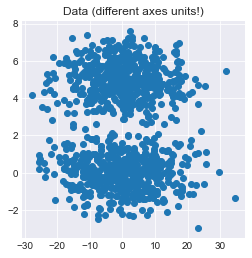

In [19]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

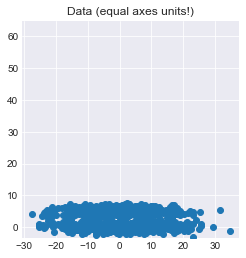

In [20]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

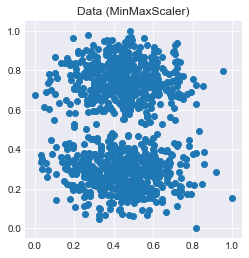

In [34]:
plot_scatter(
    MinMaxScaler().fit_transform(data[:, 0].reshape(-1, 1)),
    MinMaxScaler().fit_transform(data[:, 1].reshape(-1, 1)),
    auto_scaled=False,
    title='Data (MinMaxScaler)'
);

### StandardScaler (0.5 point)

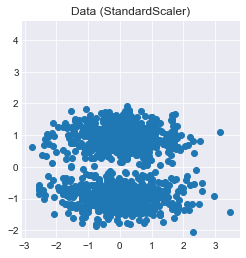

In [33]:
plot_scatter(
    StandardScaler().fit_transform(data[:, 0].reshape(-1, 1)),
    StandardScaler().fit_transform(data[:, 1].reshape(-1, 1)),
    auto_scaled=False,
    title='Data (StandardScaler)'
)

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


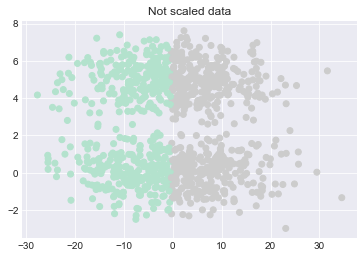

In [148]:
kmeans_model = KMeans(n_clusters=2)

clusters = kmeans_model.fit_predict(np.array([data[:, 0], data[:, 1]]).T)

plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='Pastel2')
plt.title('Not scaled data');

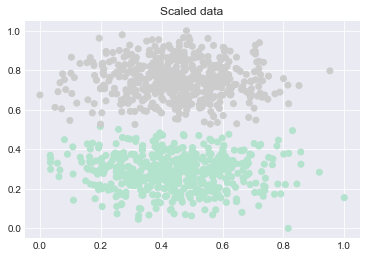

In [149]:
kmeans_model = KMeans(n_clusters=2)

x = MinMaxScaler().fit_transform(data[:, 0].reshape(-1, 1))
y = MinMaxScaler().fit_transform(data[:, 1].reshape(-1, 1))
    
clusters = kmeans_model.fit_predict(np.array([x, y]).reshape(2, -1).T)


plt.scatter(x, y, c=clusters, cmap='Pastel2')
plt.title('Scaled data');

## Exercise  3 - Preprocessing Pipeline (2 points)

In [219]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [284]:
# define the model
model = LogisticRegression(solver='liblinear', penalty='l1')
scoring_df = pd.DataFrame(columns=['scaler', 'f_selector', 'acc_score'])

In [285]:
# train model on raw data
model.fit(wine_train, wine_labels_train)
prediction = model.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'-',
                                'f_selector': '-',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

0.9814814814814815


In [286]:
# train model on sclaled data
# StandardScaler
scaled_data_model = Pipeline([('scaler', StandardScaler()),
                              ('clf', model)]
                            )
scaled_data_model.fit(wine_train, wine_labels_train)
prediction = scaled_data_model.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'StandardScaler',
                                'f_selector': '-',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

0.9814814814814815


In [287]:
# train model on sclaled data
# MinMaxScaler
scaled_data_model = Pipeline([('scaler', MinMaxScaler()),
                              ('clf', model)]
                            )
scaled_data_model.fit(wine_train, wine_labels_train)
prediction = scaled_data_model.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'MinMaxScaler',
                                'f_selector': '-',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

1.0


In [288]:
# train model on sclaled data with feature selection
# StandardScaler
# VarianceThreshold

model_VT = Pipeline([('scaler', StandardScaler()),
                     ('f_selector', VarianceThreshold()),
                     ('clf', model)]
                   )
model_VT.fit(wine_train, wine_labels_train)
prediction = model_VT.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'StandardScaler',
                                'f_selector': 'VarianceThreshold',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

0.9814814814814815


In [289]:
# train model on sclaled data with feature selection
# StandardScaler
# SelectFromModel

model_SFM = Pipeline([('scaler', StandardScaler()),
                      ('f_selector', SelectFromModel(estimator=model)),
                      ('clf', model)]
                    )
model_SFM.fit(wine_train, wine_labels_train)
prediction = model_SFM.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'StandardScaler',
                                'f_selector': 'SelectFromModel',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

0.9814814814814815


In [290]:
# train model on sclaled data with feature selection
# StandardScaler
# RFECV

model_RFECV = Pipeline([('scaler', StandardScaler()),
                        ('f_selector', RFECV(estimator=model)),
                        ('clf', model)]
                      )
model_RFECV.fit(wine_train, wine_labels_train)
prediction = model_RFECV.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'StandardScaler',
                                'f_selector': 'RFECV',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

0.9814814814814815


In [291]:
# train model on sclaled data with feature selection
# StandardScaler
# SequentialFeatureSelector

model_SeqFS = Pipeline([('scaler', StandardScaler()),
                        ('f_selector', SequentialFeatureSelector(estimator=model)),
                        ('clf', model)]
                      )
model_SeqFS.fit(wine_train, wine_labels_train)
prediction = model_SeqFS.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'StandardScaler',
                                'f_selector': 'SequentialFeatureSelector',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

0.9629629629629629


In [292]:
# train model on sclaled data with feature selection
# MinMaxScaler
# VarianceThreshold

model_VT = Pipeline([('scaler', MinMaxScaler()),
                     ('f_selector', VarianceThreshold()),
                     ('clf', model)]
                   )
model_VT.fit(wine_train, wine_labels_train)
prediction = model_VT.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'MinMaxScaler',
                                'f_selector': 'VarianceThreshold',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

1.0


In [293]:
# train model on sclaled data with feature selection
# MinMaxScaler
# SelectFromModel

model_SFM = Pipeline([('scaler', MinMaxScaler()),
                      ('f_selector', SelectFromModel(estimator=model)),
                      ('clf', model)]
                    )
model_SFM.fit(wine_train, wine_labels_train)
prediction = model_SFM.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'MinMaxScaler',
                                'f_selector': 'SelectFromModel',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

1.0


In [294]:
# train model on sclaled data with feature selection
# MinMaxScaler
# RFECV

model_RFECV = Pipeline([('scaler', MinMaxScaler()),
                        ('f_selector', RFECV(estimator=model)),
                        ('clf', model)]
                      )
model_RFECV.fit(wine_train, wine_labels_train)
prediction = model_RFECV.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'MinMaxScaler',
                                'f_selector': 'RFECV',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

0.9814814814814815


In [295]:
# train model on sclaled data with feature selection
# MinMaxScaler
# SequentialFeatureSelector

model_SeqFS = Pipeline([('scaler', MinMaxScaler()),
                        ('f_selector', SequentialFeatureSelector(estimator=model)),
                        ('clf', model)]
                      )
model_SeqFS.fit(wine_train, wine_labels_train)
prediction = model_SeqFS.predict(wine_val)
acc = accuracy_score(wine_labels_val, prediction)
scoring_df = scoring_df.append({'scaler':'MinMaxScaler',
                                'f_selector': 'SequentialFeatureSelector',
                                'acc_score': acc},
                               ignore_index=True
                              )
print(acc)

0.9074074074074074


In [296]:
scoring_df.groupby(['scaler', 'f_selector']).max()

acc_score
scaler         f_selector                          
-              -                           0.981481
MinMaxScaler   -                           1.000000
               RFECV                       0.981481
               SelectFromModel             1.000000
               SequentialFeatureSelector   0.907407
               VarianceThreshold           1.000000
StandardScaler -                           0.981481
               RFECV                       0.981481
               SelectFromModel             0.981481
               SequentialFeatureSelector   0.962963
               VarianceThreshold           0.981481

**StandardScaler** не улучшил качество предсказания (по сравнению с сырыми данными). Выбор фичей разными способами также не дало прироста к качеству (с SequentialFeatureSelector стало даже хуже).

**MinMaxScaler** улучшил качество модели. Также accuracy=1 получился с применением SelectFromModel и VarianceThreshold, но с SequentialFeatureSelector каечтсво стало хуже, а с RFECV такое же, как на сырых данных.

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [7]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [8]:
all_data = pd.concat([wine_data, wine_labels], axis=1)
all_data.shape

(178, 14)

In [9]:
S = np.cov(StandardScaler().fit_transform(wine_data), rowvar=False)
np.linalg.norm(S)

5.787241159764733

If your code is correct, the following assert should be Ok.

In [10]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [92]:
from scipy.optimize import minimize

def objective(x):
    return - x.T @ S @ x

def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    if np.linalg.norm(x) == 1:
        return 0
    return 1 - x @ x.T

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.zeros(len(S))

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [93]:
def orthogonality_constraint(x):
    if x @ x0 == 0:
        return 0
    return - x @ x0

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.zeros(wine_data.shape[1])


sol = minimize(objective, 
               x1, 
               constraints = [con1, con2]
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [94]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

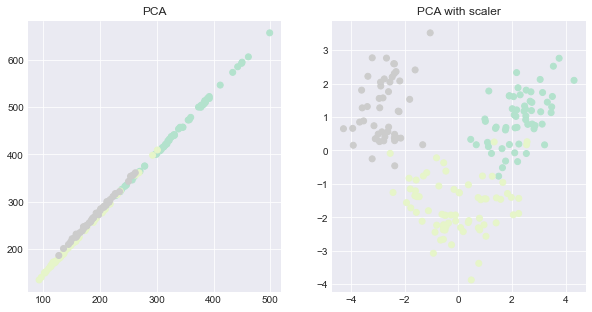

In [95]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.scatter(wine_data @ x0,
            wine_data @ x1,
            c=wine_labels,
            cmap='Pastel2',
           )
plt.title('PCA')

data = StandardScaler().fit_transform(wine_data)
plt.subplot(1,2,2)
plt.scatter(data @ x0,
            data @ x1,
            c=wine_labels,
            cmap='Pastel2'
           )
plt.title('PCA with scaler');

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [37]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

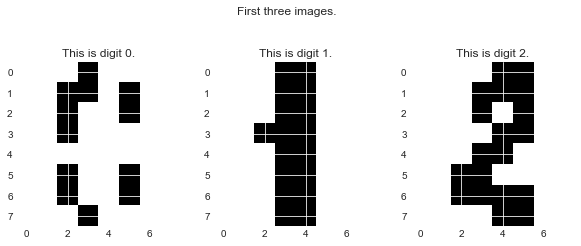

In [38]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [42]:
clf = RandomForestClassifier(max_depth=13)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(acc)

0.9876543209876543


In [43]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [45]:
# ! pip install boruta

In [65]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

feat_selector.fit(np.array(X_train), y_train)


BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x7FE3D1EB8340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FE3D1EB8340)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

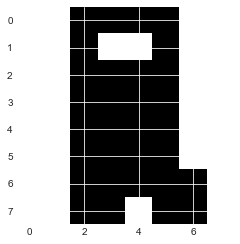

In [54]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [66]:
X_filtered_train = feat_selector.transform(np.array(X_train))
X_filtered_val = feat_selector.transform(np.array(X_val))

In [67]:
clf = RandomForestClassifier(max_depth=13)

clf.fit(X_filtered_train, y_train)
y_pred = clf.predict(X_filtered_val)

acc = accuracy_score(y_val, y_pred)
print(acc)

0.9938271604938271


In [68]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market